**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark 
- On **Quercus**, submit a ipynb file with your entire code

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [46]:
%pip install tensorflow
%pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

In [48]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:01<00:00, 41.9MB/s]


In [49]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [50]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

The "fit_on_texts" function from the keras tokenizer class creates and updates the list of words by its frequency from highest to lowest. This achieves the functionality of point 2. 

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

The "texts_to_sequences" functions transforms the text in messages into a sequence of integers. Then it returns the sequences representing the index of the words in the same highest to lowest order. This achieves the functionlity of point 3.

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

The "pad_sequences" function takes a list of sequences as an input and appends padding at the beginning of the sequence. The reason behind this is to have all the sequences be of the max length of 200. For review lengths longer, it will also only keep the first 200 max length as well.

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [51]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [52]:
print(messages_train[0])
print("Length of the first review = ", len(messages_train[0]))

[ 634   12  239  110  846   36  172   30  224  196    1  434  365   55
    3  279    7    7  157 1726  190    6    1  738 1993    1 1180    4
 1882    2  146  145    3  226    4    3  207  326    2  145 1077   16
   88    4  132   18   10  154   99    4    1  300   11   17  989   36
    1  495  492  250   73   76  106  106  696   60   85 1057 1343    5
  229  132   23   31  138  212 1133   14   31    3    2    8   11    6
    3  448   14  619    4    1  719    1 1245    2   73    1  164 1514
    1 1239    5 1674    1  888 1261    5    1  309  140    2  410  624
    7    7    1  272    6 1010    5   26   39   14 1378  217   65    2
   46    6   30  224   27  191 1473    8 1088   18   10   84    1  227
   66  358   68   54   27    5   15   44   21  193    5    3  879 1773
   22   25    5  160  197  176    3  111   12 1569  472   75  221    5
  327    2   35   23   51   71 1890   14    9 1388   11   19    6    3
   16   61    1  469  533    2    3  171 1776    5  586    9   36    1
  454 

Above I have printed the first input of the training set. It is a sequence of integers that represents the index of frequency of each word in the first review instead of the actual words of the review. Additionally, the length of the message is 200, representing the first 200 words of the review. This does match my expectation.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this mapping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [53]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

When the input is a sentence, the "__init__" function initializes a matrix with dimensions of size * latent. Here, size is equal to the number of words in the vocabulary (2000 words) and latent is equal to the embedding size (30). Therefore, this is matrix of 2000 * 30 dimension. 

When the input is a sentence, the "__call__" function transforms the sentence into it's word embeddings. So in this case the sequence that matches the sentence would be passed in to embed the words in the sentence.

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

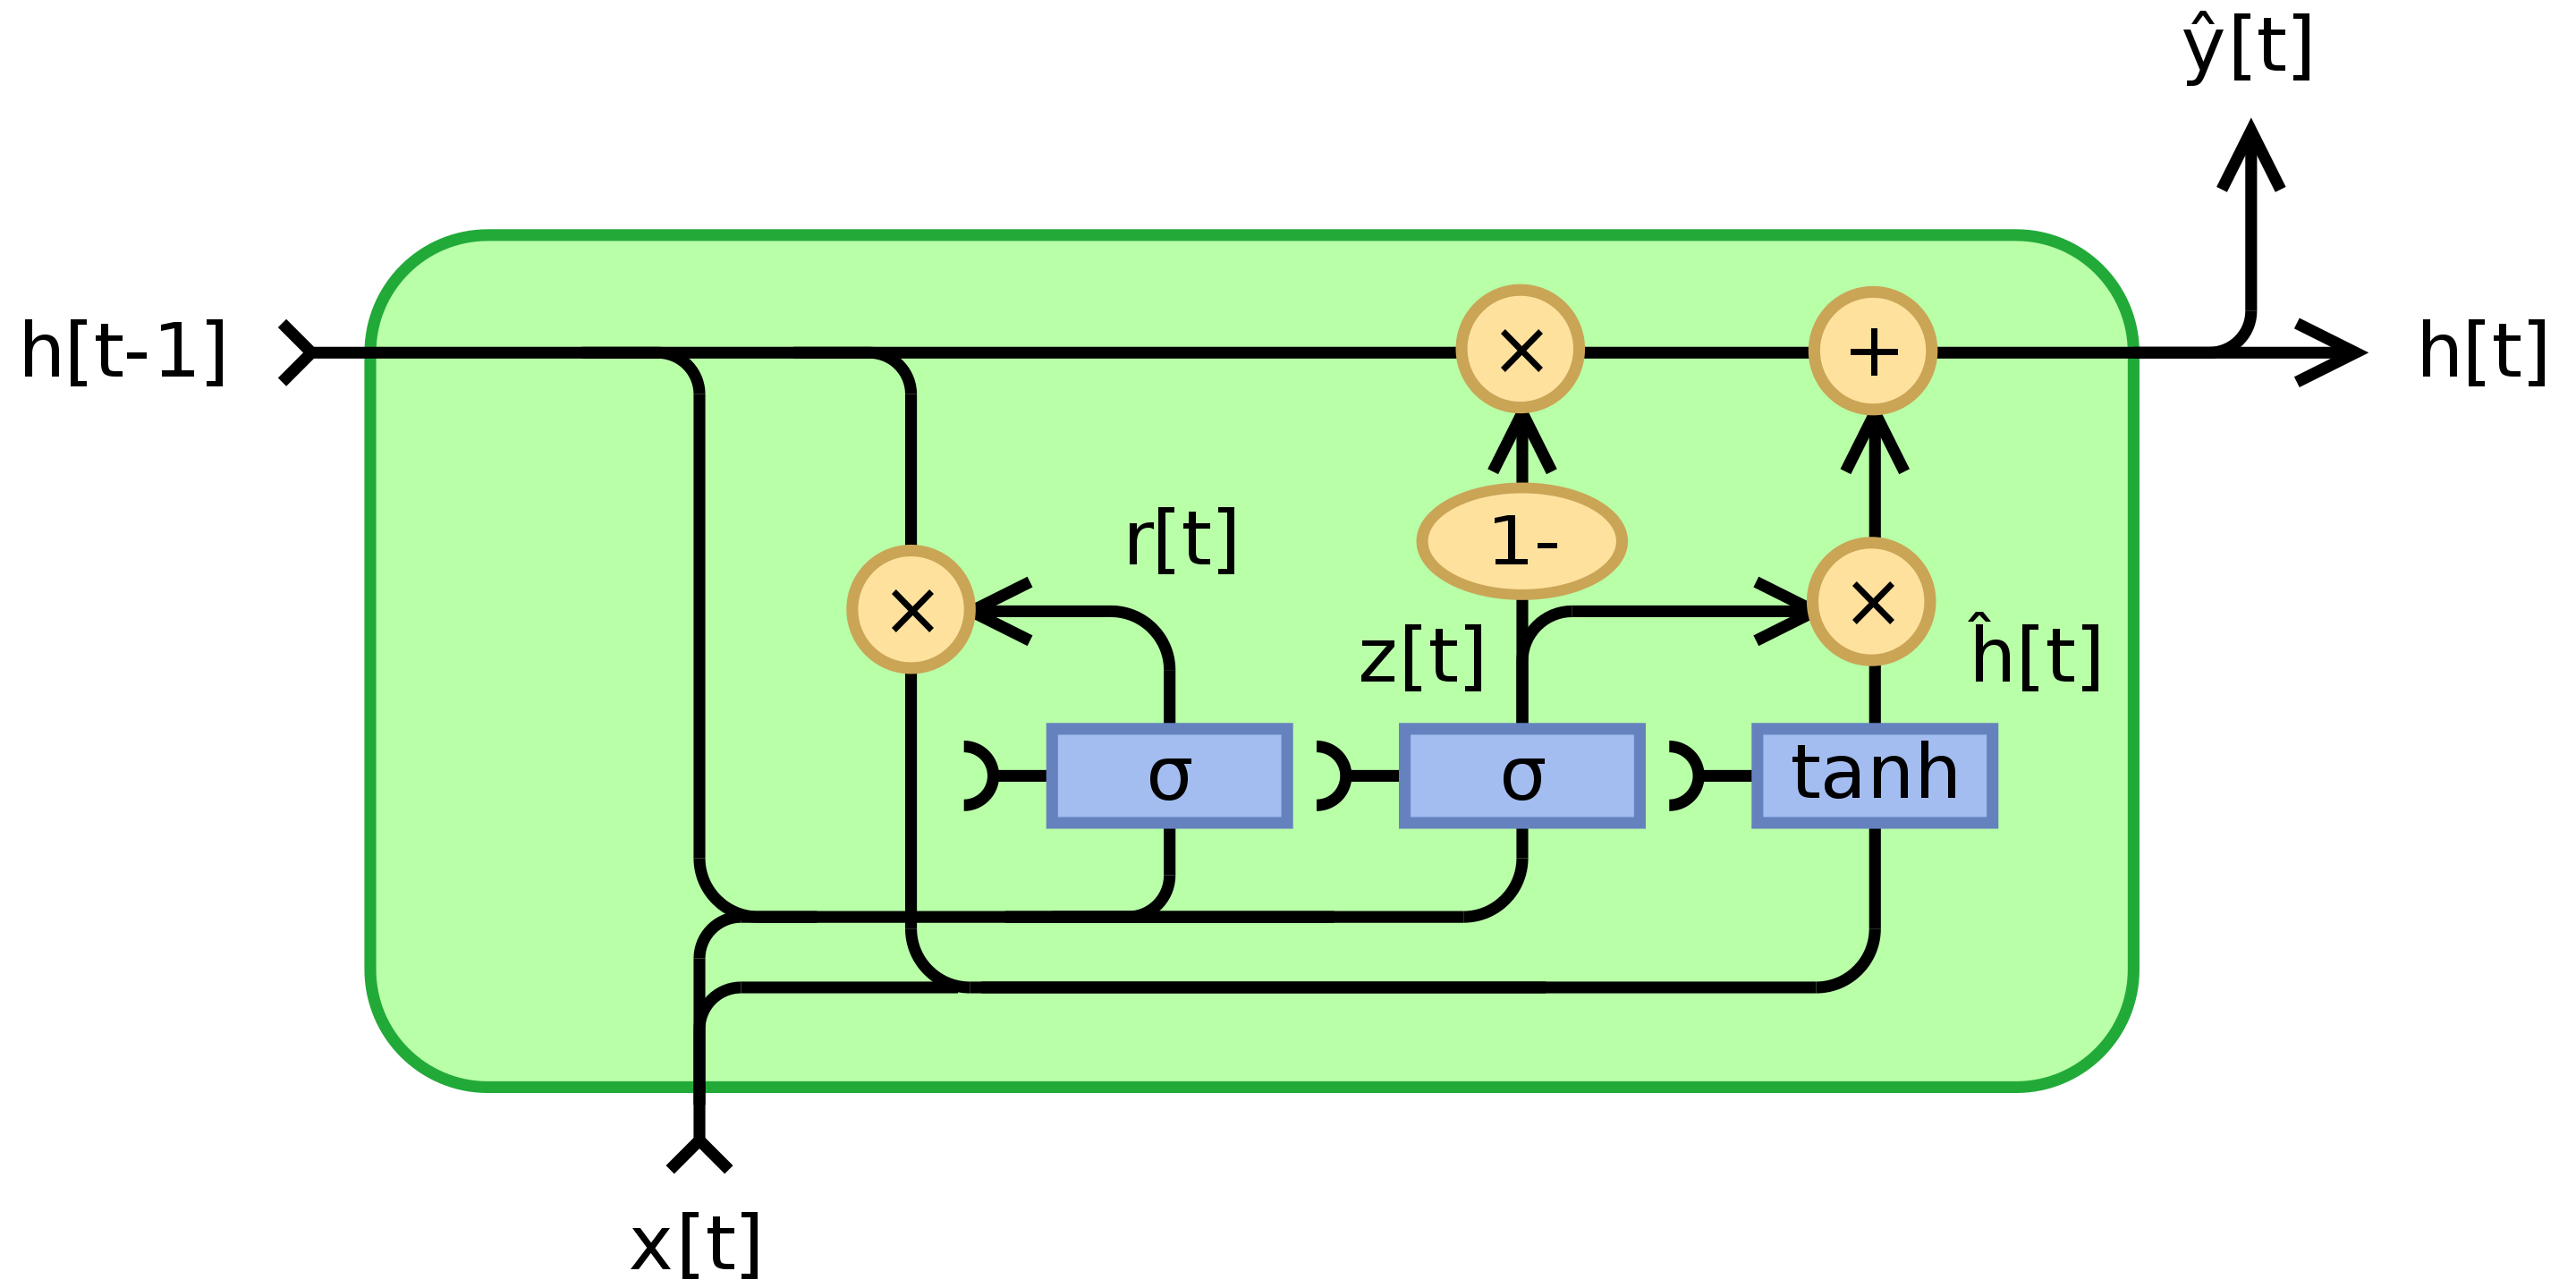

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [54]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(jn.dot(x, self.update_w.value) + jn.dot(state, self.update_u.value) + self.update_b.value)

            # fill this in
            reset_gate = objax.functional.sigmoid(jn.dot(x, self.reset_w.value) + jn.dot(state, self.reset_u.value) + self.reset_b.value)
            
            # fill this in
            output_gate = objax.functional.tanh(jn.dot(x, self.output_w.value) + jn.dot(jn.multiply(reset_gate, state), self.output_u.value) + self.output_b.value)
            
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

The function "lat.scan" is useful for improving performance of your code since it replaces the need of a for loop and is able to do the calculations in this function call. It will intake a function, an initial value, and an array as the input. 

In our example below, func is the function, and within lat.scan, it will use initial_state as the starting carry value. Then it will do the operations of the func function on the carry value and each integer of input array. The output of the function is stored back into the carry value, and the next value. These two values are subtracted by each other then returned in the result array.

In [55]:
inputArray = jn.array([20, 15, 10, 5])

# Normal Function
def subCalculations(inputArray):
  ans = []
  subVal = 0

  for num in inputArray:
    subVal -= num
    ans.append(subVal)
  print("Normal Function answer = ", jn.array(ans))
  return jn.array(ans)

# Function using lax.scan
def latScanSubCalculations(subVal, num):
  ans = subVal - num
  return ans, ans

# Running Normal Function
subCalculations(inputArray)

# Running lax.scan
carryVal, answer = lax.scan(latScanSubCalculations, 0, inputArray)
print("Lax Scan answer = ", answer)

Normal Function answer =  [-20 -35 -45 -50]
Lax Scan answer =  [-20 -35 -45 -50]


# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. 
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [56]:
# fill this in:
gru_rnn = objax.nn.Sequential([
  Embed(max_vocab, embedding_size),
  GRU(embedding_size, num_hidden_units_GRU),
  objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
  objax.functional.relu,
  objax.nn.Linear(num_hidden_units, 2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [57]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [58]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [59]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [60]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [61]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

Epoch 0001  Training Loss 172.70 Validation Loss 171.46 Training Accuracy 55.28 Validation Accuracy 57.34
Epoch 0002  Training Loss 168.61 Validation Loss 167.91 Training Accuracy 59.70 Validation Accuracy 56.50
Epoch 0003  Training Loss 162.60 Validation Loss 167.01 Training Accuracy 62.80 Validation Accuracy 58.84
Epoch 0004  Training Loss 155.93 Validation Loss 149.26 Training Accuracy 66.89 Validation Accuracy 68.82
Epoch 0005  Training Loss 149.32 Validation Loss 134.84 Training Accuracy 69.48 Validation Accuracy 72.86
Epoch 0006  Training Loss 144.48 Validation Loss 139.16 Training Accuracy 70.75 Validation Accuracy 72.52
Epoch 0007  Training Loss 140.59 Validation Loss 133.09 Training Accuracy 72.59 Validation Accuracy 73.86
Epoch 0008  Training Loss 137.51 Validation Loss 124.28 Training Accuracy 73.44 Validation Accuracy 76.08
Epoch 0009  Training Loss 135.51 Validation Loss 140.01 Training Accuracy 74.00 Validation Accuracy 75.10
Epoch 0010  Training Loss 133.19 Validation Lo

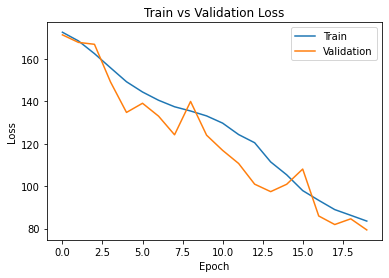

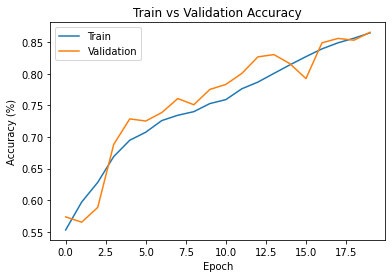

In [63]:
# Your code for the training loop should start here 
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))

  # Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

train()

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

In [66]:
print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

Test Accuracy: 86.08%


The training accuracy was 86.48%. Therefore the generalization gap between training and test accuracy is 0.40%


# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [67]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
  Embed(max_vocab, embedding_size),
  GRU(embedding_size, num_hidden_units_GRU),
  objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
  objax.functional.relu,
  objax.nn.Linear(num_hidden_units, 2)
])

In [68]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [69]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [70]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


Epoch 0001  Training Loss 118.73 Validation Loss 77.87 Training Accuracy 77.15 Validation Accuracy 86.92
Epoch 0002  Training Loss 75.62 Validation Loss 70.94 Training Accuracy 88.14 Validation Accuracy 87.96
Epoch 0003  Training Loss 66.26 Validation Loss 69.66 Training Accuracy 89.81 Validation Accuracy 88.18
Epoch 0004  Training Loss 62.21 Validation Loss 73.23 Training Accuracy 90.54 Validation Accuracy 87.64
Epoch 0005  Training Loss 60.15 Validation Loss 71.18 Training Accuracy 90.89 Validation Accuracy 88.06
Epoch 0006  Training Loss 57.58 Validation Loss 71.92 Training Accuracy 91.34 Validation Accuracy 87.86
Epoch 0007  Training Loss 54.42 Validation Loss 74.24 Training Accuracy 91.93 Validation Accuracy 87.98
Epoch 0008  Training Loss 51.46 Validation Loss 73.42 Training Accuracy 92.52 Validation Accuracy 88.16
Epoch 0009  Training Loss 47.46 Validation Loss 75.17 Training Accuracy 93.27 Validation Accuracy 88.18
Epoch 0010  Training Loss 46.10 Validation Loss 77.38 Training 

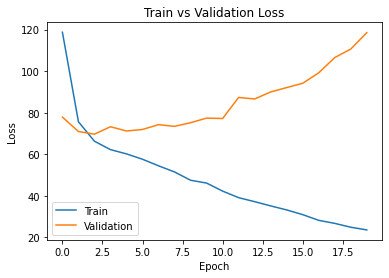

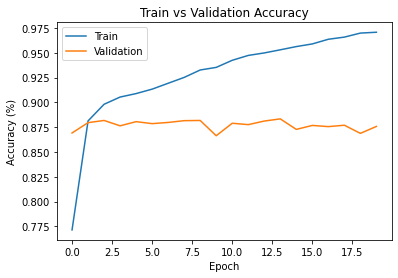

In [71]:
# Your code for the training loop should start here 
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))

  # Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

train()

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

In [72]:
print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

Test Accuracy: 86.68%


The training accuracy here was 97.07%. This training accuracy is much higher than it was when using SGD.
However, the test accuracy is around the same and same goes for validation accuracy. The new generalization gap between training and test accuracy is 10.39%. This indicates that the model has perhaps began to overfit the training data since the better training performance doesn't generalize to a better testing performance.


**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizer.

Adam optimizer is an adaptive learning rate optimization algorithm for training neural networks. It computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. Adam is able to achieve good results fast because of its design. 

Adam is an extension to SGD Optimizer by being a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.


# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [93]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
  Embed(max_vocab, embedding_size),
  GRU(embedding_size, num_hidden_units_GRU),
  objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
  objax.functional.relu,
  objax.nn.Linear(num_hidden_units, 2)
])

In [94]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [95]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [96]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

Epoch 0001  Training Loss 117.61 Validation Loss 76.09 Training Accuracy 77.31 Validation Accuracy 87.52
Epoch 0002  Training Loss 73.17 Validation Loss 70.85 Training Accuracy 88.60 Validation Accuracy 88.12
Epoch 0003  Training Loss 68.08 Validation Loss 71.01 Training Accuracy 89.35 Validation Accuracy 87.84
Epoch 0004  Training Loss 62.49 Validation Loss 69.01 Training Accuracy 90.31 Validation Accuracy 88.30
Epoch 0005  Training Loss 59.71 Validation Loss 69.30 Training Accuracy 90.81 Validation Accuracy 88.30
Epoch 0006  Training Loss 56.36 Validation Loss 71.97 Training Accuracy 91.33 Validation Accuracy 88.18
Epoch 0007  Training Loss 54.20 Validation Loss 72.03 Training Accuracy 91.73 Validation Accuracy 87.98
Epoch 0008  Training Loss 51.82 Validation Loss 72.86 Training Accuracy 92.25 Validation Accuracy 88.18
Loss sequence greater than Max Patience Window now.


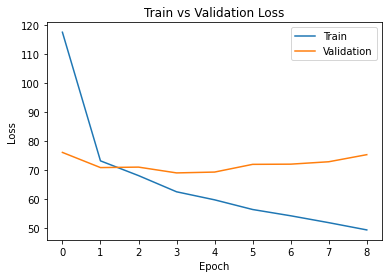

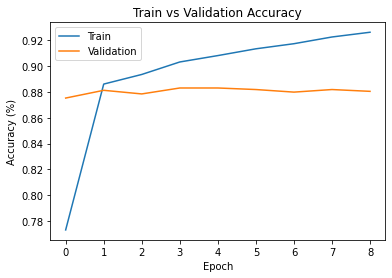

In [97]:
# Your code for the training loop should start here 
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  # Initialize Loss Increase to False
  loss_inc = False

  #Initialize Loss Sequence to 0
  loss_seq = 0

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      # Implementing early stopping method with a patience window
      if (avg_val_loss_epoch[len(avg_val_loss_epoch) - 1] > avg_val_loss_epoch[len(avg_val_loss_epoch) - 2]):
        if loss_inc:
          loss_seq += 1
        else:
          loss_inc = True
          loss_seq = 1
        
        if (loss_seq >= max_patience_window):
          print("Loss sequence greater than Max Patience Window now.")
          break
      else:
        loss_inc = False

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
  
  # Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

train()

In [98]:
print(f"Test Accuracy: {round(float(accuracy(test_data))*100,2)}%")

Test Accuracy: 88.0%


**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

The third and last model has the best validation accuracy and has the best test accuracy.

Validation Accuracy = 88.18%
Test Accuracy = 88.0%